### Montamos la unidad de drive - Importamos librerías y cargamos paths

In [0]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

In [0]:
# Instalar librería para pinitar mapa
!apt-get install libgeos-3.5.0
!apt-get install libgeos-dev
!pip install https://github.com/matplotlib/basemap/archive/master.zip

In [0]:
import pandas as pd
from keras.models import load_model

# Cambiar esta línea al directorio de trabajo pertinente
files_path = "/content/drive/My Drive/HARVIS_UC2/BBDD/FR1193_Toulouse_Seville/"

# Se usarán para predecir la trayectoria final a utilizar para elegir el modelo de regresión
metar1_path = 'metar_1_clean.csv'  # Archivo con info metar1
metar2_path = 'metar_2_clean.csv'  # Archivo con info metar2

# Datos de trayectoria completos juntos en un mismo archivo
traj_path = 'trajectories.csv' 

# Archivo con información de Ground Truth - creados con kmeans
gt_path = 'gt_data.csv'     

# Cargamos datos
traj = pd.read_csv(files_path + traj_path, sep=",")
gt = pd.read_csv(files_path + gt_path, sep=",")


### Tratamiento datos de salida (Ground-Truth)

Leemos los datos de salida posibles y los pasamos a numérico y a one-hot-encoding

In [0]:
import numpy as np
from keras.utils import to_categorical

gt_labels = ['Rotex','Santa']
gt_num = []

for flight_id, name in zip(gt['Flight_id'], gt['gt_label']):
  fl_id = flight_id.split('_')[-1]
  label = 0
  for j in gt_labels:
    if name == j:
      gt_num.append([fl_id ,label])
    label += 1

# One-Hot-Encoding
y_gt = np.array(to_categorical([item[-1] for item in gt_num]))

### Tratamiento datos de trayectoria

Pasamos las variables a formato float y nos quedamos los datos

In [0]:
import re
variables = ['hour', 'minute', 'second', 'altitude', 'direction', 'latitude', 'longitude', 'speed']
for v in variables:
  n = 0
  for i in traj[v]:  
    result = re.search('\[(.*)\]', i)
    traj[v][n] = [float(j) for j in result.group(1).split(',')]
    n +=1
fl_id_list = list(traj['fl_id'])

In [0]:
# Separar una serie de datos secuenciales de una sola variable en muestras diferentes y la salida - Preparación para LSTM univariate
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		end_ix = i + n_steps # Fin de secuencia
		if end_ix > len(sequence)-1: # Comprobar si hemos rebasado el final
			break
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix] # Separar entre entrada y salida
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)


In [0]:
import numpy as np
# Separar una serie de datos secuenciales de una varas variables en muestras diferentes y la salida - Preparación para LSTM multivariate
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
# Normalizamos los datos de trayectoria respecto de los máximos y mínimos (no siguen una distribución gaussiana)
def normalize_data(x_data, min_value, max_value):
  # Normalizamos datos de entrada entre un mínimo y máximo para obtener un valor entre 0 y 1
  # x_data tiene shape = (samples, timestemps)
  x_norm = np.zeros(x_data.shape)
  x_norm = (x_data-min_value)/(max_value-min_value)

  return x_norm

# Denormalizar los datos para crear la predicción en valores (coordenadas y altitud) reales
def denormalize_data(norm_data, min_value, max_value):
  # Desormalizamos datos normalizados entre 0 y 1 para obtener entre mínimo y máximo 
  # x_data tiene shape = (samples, timestemps)
  x_data = np.zeros(norm_data.shape)
  x_data = (norm_data*(max_value-min_value))+min_value

  return x_data

In [0]:
## TODO: modificar este método para que sea funcional en este caso y poder crear las particiones de test y train

# Mezclar datos de train y test y crear particiones
def shuffle_and_partition(x_traj, id_list, y, trainP):
  # x=inputs, y=outputs, trainP=porcentaje de train
  s = np.arange(x_traj.shape[0])
  np.random.shuffle(s)
  x_traj, id_list, y = x_traj[s], np.array(id_list)[s], y[s]

  # Asignamos particiones de train y test
  n_part = round(trainP*len(x_metar))

  x_traj_train, x_traj_test, id_list_train, id_list_test, y_train, y_test = x_traj[:n_part], x_traj[n_part:], id_list[:n_part], id_list[n_part:], y[:n_part], y[n_part:]
  return x_traj_train, x_traj_test, id_list_train, id_list_test, y_train, y_test

### Univariate LSTM

In [0]:
# univariate lstm example
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense

n_steps = 10
n_features = 1 

X, Y = np.zeros([0,n_steps]), np.zeros([0,n_steps])

for i in range(len(traj)):
  data = normalize_data(np.array(traj['altitude'][i]), 0, 40000)
  x1, y1 = split_sequence(data, n_steps)
  X = np.insert(X, len(X), x1, axis=0)
  Y = np.append(Y, y1)

# Reshape para introducri en red LSTM
X = X.reshape(X.shape[0],X.shape[1],n_features) # samples-timesteps-features


# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, Y, epochs=20, batch_size=100, verbose=1)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





41638/41638 [==============================] - 6s 148us/step - loss: 0.0198
Epoch 2/20
41638/41638 [==============================] - 5s 120us/step - loss: 0.0049
Epoch 3/20
41638/41638 [==============================] - 5s 122us/step - loss: 0.0038
Epoch 4/20
41638/41638 [==============================] - 5s 120us/step - loss: 0.0032
Epoch 5/20
41638/41638 [==============================] - 5s 120us/step - loss: 0.0029
Epoch 6/20
41638/41638 [==============================] - 5s 122us/step - loss: 0.0027
Epoch 7/20
41638/41638 [==============================] - 5s 124us/step - loss: 0.0025
Epoch 8/20
41638/41638 [==============================] - 5s 121us/step - loss: 0.0024
Epoch 9/20
41638/41638 [==============================] - 5s 125us/step - loss: 0.

In [0]:
# demonstrate prediction
k = 106 # Medida a predecir
x_input = normalize_data(np.array(traj['altitude'][0][k-10:k]), 0, 40000)
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print('- Predicted: {}\n- Real: {}'.format(denormalize_data(yhat, 0, 40000)[0][0], traj['altitude'][0][k]))

- Predicted: 36566.91015625
- Real: 37000.0


### Multivariate LSTM

Creamos 2 redes LSTM, una para cada posible trayectoria

In [0]:
## Hiperparámetros
n_steps = 20 # Timesamples a tener en cuenta por a red LSTM para predecir
n_features = 3 
epochs = 25
batch_size = 50 
validation_split = 0.1

In [0]:
### Red-LSTM 1: trayectorias por y_gt = 0 = ROTEX

# multivariate output stacked lstm example
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Bidirectional
from keras.layers import Dense, Dropout
from keras.optimizers import SGD
import matplotlib.pyplot as plt
 

# Formato deseado: (samples-timesteps-features)
X1 = np.zeros([0, n_steps, n_features])
Y1 = np.zeros([0,n_features])

traj1 = np.where(np.argmax(y_gt, axis=1)==0) # Trayectorias que pasan por Rotex

for i in traj1[0]:
	# define input sequence
	in_seq1 = normalize_data(np.array(traj['altitude'][i]), 0, 40000)
	in_seq2 = normalize_data(np.array(traj['latitude'][i]), 35,45)
	in_seq3 = normalize_data(np.array(traj['longitude'][i]), -10, 3)
	
	# convert to [rows, columns] structure
	in_seq1 = in_seq1.reshape((len(in_seq1), 1))
	in_seq2 = in_seq2.reshape((len(in_seq2), 1))
	in_seq3 = in_seq3.reshape((len(in_seq3), 1))
 
	# horizontally stack columns
	sample_dataset = np.hstack((in_seq1, in_seq2, in_seq3))
	# convert into input/output
	x, y = split_sequences(sample_dataset, n_steps)
	X1 = np.insert(X1, len(X1), x, axis=0) # añadimos en última posición
	Y1 = np.insert(Y1, len(Y1), y, axis=0)
 
# define model
model1 = Sequential()
model1.add(LSTM(50, activation='linear', return_sequences=False, input_shape=(n_steps, n_features)))
model1.add(Dropout(0.2))
model1.add(Dense(n_features))

model1.compile('adam',loss='mse',metrics=["mse"])
# fit model
H1 = model1.fit(X1, Y1, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=validation_split)



Train on 23652 samples, validate on 2628 samples
Epoch 1/25
23652/23652 [==============================] - 10s 414us/step - loss: 0.0120 - mean_squared_error: 0.0120 - val_loss: 9.9666e-04 - val_mean_squared_error: 9.9666e-04
Epoch 2/25
23652/23652 [==============================] - 9s 396us/step - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 4.7447e-04 - val_mean_squared_error: 4.7447e-04
Epoch 3/25
23652/23652 [==============================] - 9s 392us/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 3.5904e-04 - val_mean_squared_error: 3.5904e-04
Epoch 4/25
23652/23652 [==============================] - 9s 387us/step - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 3.3737e-04 - val_mean_squared_error: 3.3737e-04
Epoch 5/25
23652/23652 [==============================] - 9s 393us/step - loss: 0.0020 - mean_squared_error: 0.0020 - val_loss: 4.2032e-04 - val_mean_squared_error: 4.2032e-04
Epoch 6/25
23652/23652 [==============================] - 9s 390us/ste

In [0]:
### Red-LSTM 2: trayectorias por y_gt = 1 = SANTA

# Formato deseado: (samples-timesteps-features)
X2 = np.zeros([0, n_steps, n_features])
Y2 = np.zeros([0,n_features])

traj2 = np.where(np.argmax(y_gt, axis=1)==1) # Trayectorias que pasan por Santa

for i in traj2[0]:
	# define input sequence
	in_seq1 = normalize_data(np.array(traj['altitude'][i]), 0, 40000) # Entrenamos sólo sobre últimos puntos de la trayectoria [-100:]
	in_seq2 = normalize_data(np.array(traj['latitude'][i]), 35,45)
	in_seq3 = normalize_data(np.array(traj['longitude'][i]), -10, 3)
	
	# convert to [rows, columns] structure
	in_seq1 = in_seq1.reshape((len(in_seq1), 1))
	in_seq2 = in_seq2.reshape((len(in_seq2), 1))
	in_seq3 = in_seq3.reshape((len(in_seq3), 1))
 
	# horizontally stack columns
	sample_dataset = np.hstack((in_seq1, in_seq2, in_seq3))
	# convert into input/output
	x, y = split_sequences(sample_dataset, n_steps)
	X2 = np.insert(X2, len(X2), x, axis=0) # añadimos en última posición
	Y2 = np.insert(Y2, len(Y2), y, axis=0)
 
# define model
model2 = Sequential()
model2.add(LSTM(50, activation='linear', return_sequences=False, input_shape=(n_steps, n_features)))
model.add(Dropout(0.2))
model2.add(Dense(n_features))

model2.compile('adam', loss='mse', metrics=["mse"])
# fit model
H2 = model2.fit(X2, Y2, epochs=epochs, verbose=1, batch_size=batch_size, validation_split=validation_split)



Train on 11689 samples, validate on 1299 samples
Epoch 1/25
11689/11689 [==============================] - 6s 488us/step - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 2/25
11689/11689 [==============================] - 4s 384us/step - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 7.9936e-04 - val_mean_squared_error: 7.9936e-04
Epoch 3/25
11689/11689 [==============================] - 4s 384us/step - loss: 6.3390e-04 - mean_squared_error: 6.3390e-04 - val_loss: 6.1078e-04 - val_mean_squared_error: 6.1078e-04
Epoch 4/25
11689/11689 [==============================] - 5s 385us/step - loss: 4.5315e-04 - mean_squared_error: 4.5315e-04 - val_loss: 3.9131e-04 - val_mean_squared_error: 3.9131e-04
Epoch 5/25
11689/11689 [==============================] - 5s 391us/step - loss: 3.3918e-04 - mean_squared_error: 3.3918e-04 - val_loss: 4.1150e-04 - val_mean_squared_error: 4.1150e-04
Epoch 6/25
11689/11689 [==============================]

### Pruebas

In [0]:
tr_id = 1
last_measure = -90

pred_lat, pred_lon, pred_alt = list(), list(), list()

input_alt = normalize_data(np.array(traj['altitude'][tr_id][last_measure-n_steps:last_measure]), 0, 40000)
input_lat = normalize_data(np.array(traj['latitude'][tr_id][last_measure-n_steps:last_measure]), 35, 45)
input_lon = normalize_data(np.array(traj['longitude'][tr_id][last_measure-n_steps:last_measure]), -10, 3)

dataset= np.array([input_alt, input_lat, input_lon])
x_input = dataset.reshape((1, n_steps, n_features))

# models = [model1, model2]
# model = models[pred_mlp]
# Elejimos el modelo según la trayectoria
if tr_id in traj1[0]: model = model1
elif tr_id in traj2[0]: model = model2

for i in range(abs(last_measure)):
  yhat = model.predict(x_input, verbose=0)

  pred_alt.append(denormalize_data(yhat[0,0], 0, 40000))
  pred_lat.append(denormalize_data(yhat[0,1], 35, 45))
  pred_lon.append(denormalize_data(yhat[0,2], -10, 3))

  x_input = np.vstack([x_input[0], yhat[0]])[1:]
  x_input = x_input.reshape((1, n_steps, n_features))


output_alt = np.concatenate([np.array(traj['altitude'][tr_id][:last_measure]), pred_alt])
output_lat = np.concatenate([np.array(traj['latitude'][tr_id][:last_measure]), pred_lat])
output_lon = np.concatenate([np.array(traj['longitude'][tr_id][:last_measure]), pred_lon])
                     


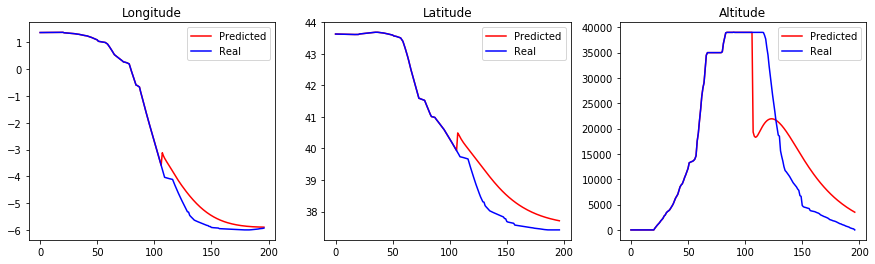

In [0]:
fig = plt.figure(figsize=(15, 4))
ax = fig.add_subplot(131)

labels = ['Predicted', 'Real']

ax.title.set_text('Longitude')
ax.plot(output_lon, 'r')
ax.plot(traj['longitude'][tr_id], 'b')
ax.legend(labels)

ax = fig.add_subplot(132)
ax.title.set_text('Latitude')
ax.plot(output_lat, 'r')
ax.plot(traj['latitude'][tr_id], 'b')
ax.legend(labels)

ax = fig.add_subplot(133)
ax.title.set_text('Altitude')
ax.plot(output_alt, 'r')
ax.plot(traj['altitude'][tr_id], 'b')
ax.legend(labels)


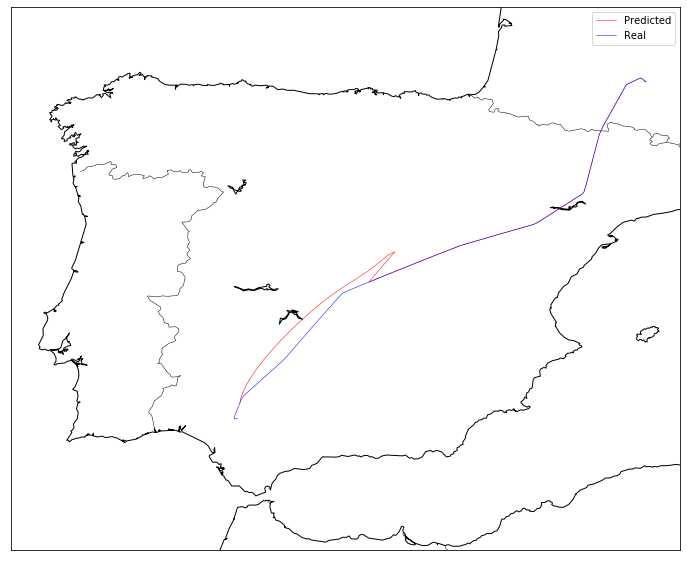

In [0]:
from mpl_toolkits.basemap import Basemap

BBox = [-10, 2, 35, 45] # Longitud (min-max) y latitud (min-max)

fig = plt.figure(figsize=((BBox[1]-BBox[0]), BBox[3]-BBox[2]))
ax = fig.add_subplot(111)

ax.set_xlim((BBox[0], BBox[1]))
ax.set_ylim((BBox[2], BBox[3]))

m = Basemap(resolution='i', llcrnrlon=BBox[0], llcrnrlat=BBox[2], urcrnrlon=BBox[1], urcrnrlat=BBox[3], fix_aspect=False)
m.drawcoastlines()
m.drawcountries()

ax.plot(output_lon, output_lat, linewidth=0.5, c='r')
ax.plot(traj['longitude'][tr_id], traj['latitude'][tr_id], linewidth=0.5, c='b')

ax.legend(labels)
